This notebook accompanies the LMC results and plotting them

# Intro

In [82]:
import wandb
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import json 
from pathlib import Path
from typing import Dict
from textwrap import wrap

from lmc.logging.plot_utils import *
from lmc.logging import *
from lmc.logging.wandb_utils import get_timeseries_metrics_from_wandb
from importlib import reload 
from lmc.utils import Step
import re

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
api = wandb.Api()
out = Path("out/perturb-at-t")
out.mkdir(exist_ok=True, parents=True)

project_path="gsaltintas/ButterflyBatchNoiseNew"
runs = api.runs(project_path, filters={"tags": {"$nin": ["ignore", "delete"]}})

len(runs)

166

Sample metric use

In [84]:
from lmc.logging import WandbMetricsRegistry, MetricCategory, LMCMetricType

%load_ext autoreload
%autoreload 2
epsilon_label = "\lambda"


r = WandbMetricsRegistry(2)
[m.category for (n, m) in r.get_lmc_metrics()]
r.get_metrics_by_category(category=MetricCategory.ACCURACY)


# Get all LMC metrics
accuracy_metrics = r.get_metrics_by_category(MetricCategory.ACCURACY)

# Get specific LMC barrier metrics
barrier_metrics = r.get_lmc_metrics(MetricCategory.LMC_ACCURACY)

accuracy_metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MetricsRegistry(metrics={'train_accuracy_1': WandbMetric(log_name='model1/train/accuracy', ylabel='$\\mathrm{Acc}^{1}_{\\mathrm{Tr}}$', prefix='model1-acc', category=<MetricCategory.ACCURACY: 'accuracy'>, split=<Split.TRAIN: 'train'>, general_ylabel='$\\mathrm{Acc}^{1}_{\\mathrm{}}$', flat_name='model1.train.accuracy'), 'test_accuracy_1': WandbMetric(log_name='model1/test/accuracy', ylabel='$\\mathrm{Acc}^{1}_{\\mathrm{Te}}$', prefix='model1-acc', category=<MetricCategory.ACCURACY: 'accuracy'>, split=<Split.TEST: 'test'>, general_ylabel='$\\mathrm{Acc}^{1}_{\\mathrm{}}$', flat_name='model1.test.accuracy'), 'train_accuracy_2': WandbMetric(log_name='model2/train/accuracy', ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{Tr}}$', prefix='model2-acc', category=<MetricCategory.ACCURACY: 'accuracy'>, split=<Split.TRAIN: 'train'>, general_ylabel='$\\mathrm{Acc}^{2}_{\\mathrm{}}$', flat_name='model2.train.accuracy'), 'test_accuracy_2': WandbMetric(log_name='model2/test/accuracy', ylabel='$\\mathrm{Acc}^{2

# Butterfly - Perturbance 

## Gaussian

In [85]:
import wandb
api.flush()

project="gsaltintas/ButterflyBatchNoiseNew"

filters = {
            "state": {"$nin": ["crashed"]},
           "tags": {"$nin": ["ignore", "ignor", "hidden", "delete", "wrong-scaling"]},
          }

grad_runs = api.runs(project, 
                      filters=filters
                    )
# grad_runs = [run for run in grad_runs if len(run.config.get("dont_perturb_module_patterns", [])) > 0]
grad_runs = [run for run in grad_runs if len(run.config.get("dont_perturb_module_patterns", [])) == 0]
len(grad_runs)


145

In [86]:
# from mc.utils.report_utils import get_merged_df
from lmc.logging.wandb_utils import get_merged_df
from lmc.logging.wandb_registry import WandbMetricsRegistry

main_df, registry = get_merged_df(grad_runs, scale_barriers=False, performance_aware=False, find_missing=False, return_registry=True)
wandb_keys = WandbMetricsRegistry(main_df["n_models"].max())

na_filters = (
    (main_df["model1.test.accuracy"] != "null") 
    & (main_df["model1.train.cross_entropy"] != "NaN") 
    & (~main_df["model1.train.cross_entropy"].isna()) 
    & (~main_df["model2.train.cross_entropy"].isna()) 
)

merged_df = main_df[na_filters]
# Combine filters and apply them in one step
# merged_df = merged_df.apply(rename_opt_lr, axis=1)
# code_name = merged_df["run.group"].apply(extract_model_name).apply(correct_cases).rename("code_name")
# Calculate mean and use pd.concat for efficiency
average_test_acc = (merged_df[["model1.test.accuracy", "model2.test.accuracy"]].mean(axis=1) * 100).rename("average_test_acc")
average_train_acc = (merged_df[["model1.train.accuracy", "model2.train.accuracy"]].mean(axis=1) * 100).rename("average_train_acc")
merged_df = pd.concat([merged_df, average_test_acc, average_train_acc], axis=1)
merged_df.loc[merged_df["perturb_step"] == -1, "perturb_step"] = 0

# further_filters = (
#      (merged_df["trainer.opt.lr"] == 0.1)
#     & check_nulls(merged_df, wandb_keys.get_metric("lmc_loss_train_0_1").flat_name)
#     & (merged_df["average_test_acc"] >= 0.7)
#     & (merged_df["model2.test.accuracy"] >= 0.8)
#     & (merged_df["epoch"] >= 50)
# )

/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:141: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["trainer.opt.warmup_ratio"].fillna(0, inplace=True)


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:118: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


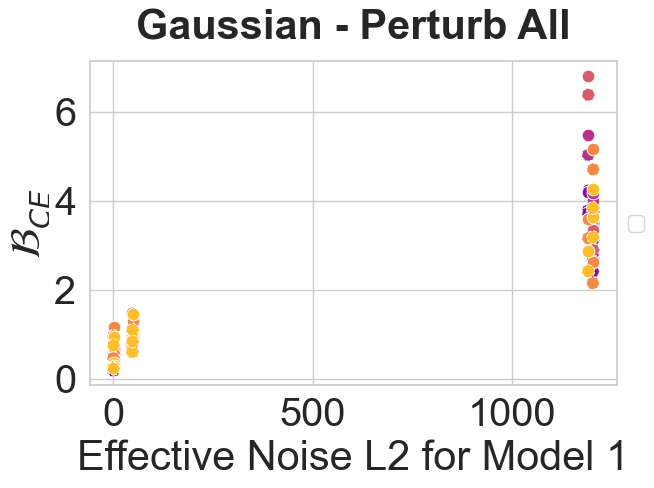

In [90]:
from lmc.logging.plot import plot_perturb_barrier
perturb_method = "batch"
perturb_method = "gaussian"
base_name = "lmc_train_0_1"
base_name = "lmc_loss_train_0_1"
zoom = "first"
# zoom = None
# zoom = "last"
title = f"{perturb_method} - No perturb bias and norm".title()
title = f"{perturb_method} - Perturb all".title()
x_metric = "noise_l2_scaled_1"
labels = ["perturb_step"]

t = plot_perturb_barrier(merged_df, registry, perturb_method, base_name, zoom=zoom, filter_bad_runs=False, separate_legend=False, plot_type="scatter", title=title, x_metric=x_metric, labels=labels)

/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:118: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


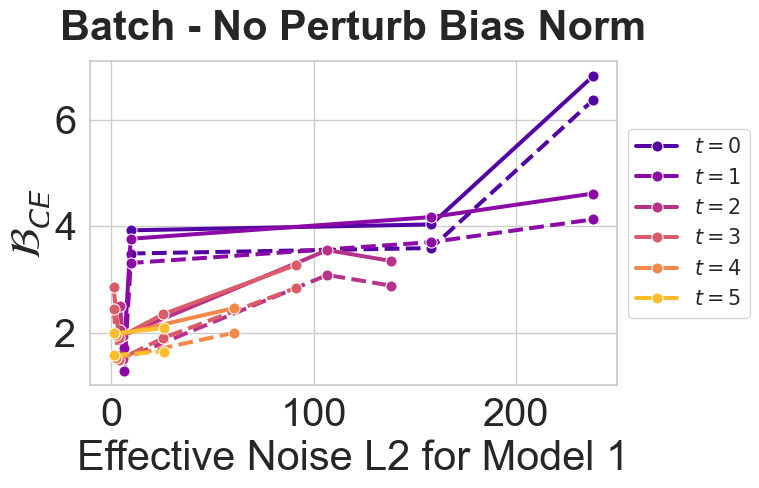

In [81]:
from lmc.logging.plot import plot_perturb_barrier
perturb_method = "batch"
# perturb_method = "gaussian"
base_name = "lmc_train_0_1"
base_name = "lmc_loss_train_0_1"
zoom = "first"
zoom = None
# zoom = "last"
x_metric = "noise_l2_scaled_1"
title=f"{perturb_method} - No perturb Bias Norm".title()
legend_template = r"$t={{{}}}$"

t = plot_perturb_barrier(merged_df, registry, perturb_method, base_name, x_metric=x_metric, zoom=zoom, filter_bad_runs=False, separate_legend=False, labels=["perturb_step"], save_fig=False, plot_type="line", title=title, legend_template=legend_template)

## Butterfly - No Perturb Weights

In [91]:
import wandb
api.flush()

project="gsaltintas/BatchNoisePerturbNorm"

filters = {
            "state": {"$nin": ["crashed"]},
           "tags": {"$nin": ["ignore", "ignor", "hidden", "delete", "wrong-scaling"]},
          }

grad_runs = api.runs(project, 
                      filters=filters
                    )
len(grad_runs)

40

In [92]:

main_df, registry = get_merged_df(grad_runs, scale_barriers=False, performance_aware=False, find_missing=False, return_registry=True)
wandb_keys = WandbMetricsRegistry(main_df["n_models"].max())

na_filters = (
    (main_df["model1.test.accuracy"] != "null") 
    & (main_df["model1.train.cross_entropy"] != "NaN") 
    & (~main_df["model1.train.cross_entropy"].isna()) 
    & (~main_df["model2.train.cross_entropy"].isna()) 
)

merged_df = main_df[na_filters]
# Combine filters and apply them in one step
# merged_df = merged_df.apply(rename_opt_lr, axis=1)
# code_name = merged_df["run.group"].apply(extract_model_name).apply(correct_cases).rename("code_name")
# Calculate mean and use pd.concat for efficiency
average_test_acc = (merged_df[["model1.test.accuracy", "model2.test.accuracy"]].mean(axis=1) * 100).rename("average_test_acc")
average_train_acc = (merged_df[["model1.train.accuracy", "model2.train.accuracy"]].mean(axis=1) * 100).rename("average_train_acc")
merged_df = pd.concat([merged_df, average_test_acc, average_train_acc], axis=1)
merged_df.loc[merged_df["perturb_step"] == -1, "perturb_step"] = 0


/Users/gsaltintas/code/thesis/clean/lmc/logging/wandb_utils.py:141: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["trainer.opt.warmup_ratio"].fillna(0, inplace=True)


/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:118: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


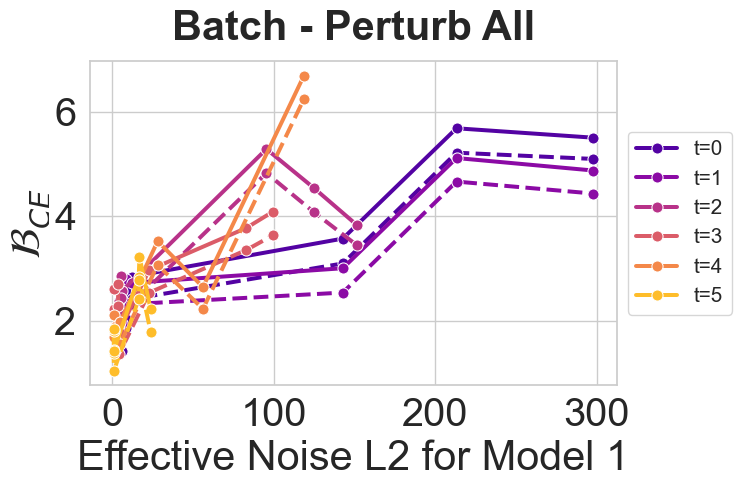

/Users/gsaltintas/code/thesis/clean/lmc/logging/report_utils.py:118: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  masks[name] = grouped.get_group(g).index


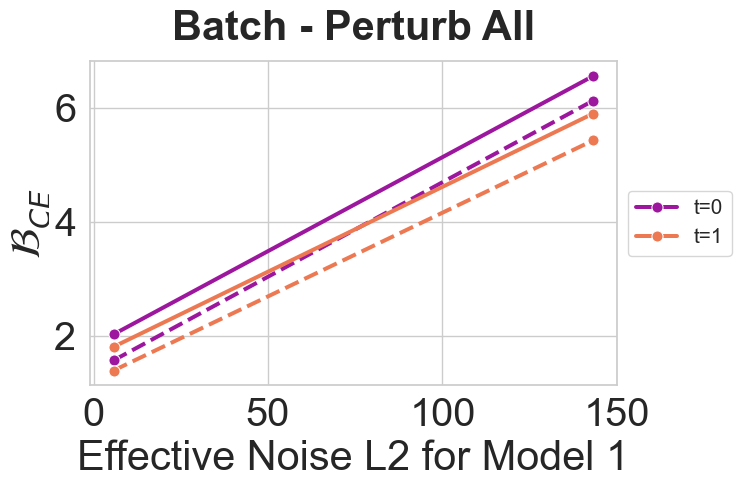

In [103]:
from lmc.logging.plot import plot_perturb_barrier
perturb_method = "batch"
# perturb_method = "gaussian"
base_name = "lmc_train_0_1"
base_name = "lmc_loss_train_0_1"
zoom = "first"
# zoom = None
# zoom = "last"
title = f"{perturb_method} - No perturb bias and norm".title()
title = f"{perturb_method} - Perturb all".title()
x_metric = "noise_l2_scaled_1"
labels = ["perturb_step", "dont_perturb_module_patterns"]
labels = ["perturb_step"]
legend_template="t={}"

filtered1 = merged_df[merged_df["dont_perturb_module_patterns"] == "['.*\\\\.bias$', '.*\\\\.conv\\\\..*', '.*\\\\.fc\\\\..*']"]
t = plot_perturb_barrier(filtered1, registry, perturb_method, base_name, zoom=zoom, filter_bad_runs=False, 
                         separate_legend=False, plot_type="line", title=title, x_metric=x_metric, labels=labels, legend_template=legend_template)



filtered2 = merged_df[merged_df["dont_perturb_module_patterns"] == "['.*\\\\.conv\\\\..*', '.*\\\\.fc\\\\..*']"]
t = plot_perturb_barrier(filtered2, registry, perturb_method, base_name, zoom=zoom, filter_bad_runs=False, 
                         separate_legend=False, plot_type="line", title=title, x_metric=x_metric, labels=labels, legend_template=legend_template)

In [99]:
merged_df["dont_perturb_module_patterns"].unique()

array(["['.*\\\\.conv\\\\..*', '.*\\\\.fc\\\\..*']",
       "['.*\\\\.bias$', '.*\\\\.conv\\\\..*', '.*\\\\.fc\\\\..*']"],
      dtype=object)